In [1]:
# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
# matplotlib日本語化対応
import japanize_matplotlib

In [2]:
# データ
url = './20220310_netstat.csv'
# データ読み込み
df = pd.read_csv(url)
#整形
#-------------------------------------------------------
#CSVの問題が混入するので排除
#https://note.nkmk.me/python-pandas-drop/
df = df.drop(columns=df.columns[[0]])
#-------------------------------------------------------
#1行1件と扱うので重み（列）を追加
#https://note.nkmk.me/python-pandas-assign-append/
df['COUNT'] = 1
#-------------------------------------------------------
#stringに変更する
df['PROTOCOL'] = df['PROTOCOL'].astype(str) #object
df['TO_ADDR'] = df['TO_ADDR'].astype(str) #object
df['TO_PORT'] = df['TO_PORT'].astype(str) #int64
df['FROM_ADDR'] = df['FROM_ADDR'].astype(str) #object
df['FROM_PORT'] = df['FROM_PORT'].astype(str) #object
df['STATUS'] = df['STATUS'].astype(str) #object
#DATETIMEをdatetime型に
#https://note.nkmk.me/python-pandas-datetime-timestamp/
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
##DATETIMEをDatetimeIndexとして指定
#https://note.nkmk.me/python-pandas-time-series-datetimeindex/
df.set_index('DATETIME', inplace=True)
#-------------------------------------------------------
print(df.dtypes)
# 結果確認
#display(df.head())
#print(df['PROTOCOL'].unique())
#print(df['TO_ADDR'].unique())
#print(df['STATUS'].unique())
#print(df.describe(exclude='number'))
#-------------------------------------------------------
#DATETIME 2022/3/4 0:00 より正常結果とする
#https://note.nkmk.me/python-pandas-drop/
df = df.loc[dt.datetime(2022,3,4):]

PROTOCOL     object
TO_ADDR      object
TO_PORT      object
FROM_ADDR    object
FROM_PORT    object
STATUS       object
COUNT         int64
dtype: object


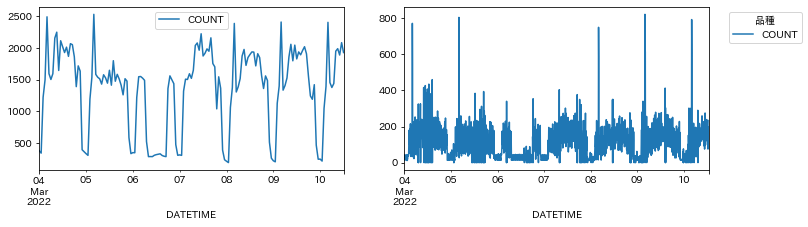

In [3]:
#df_t = df.resample('H').sum()
#df_t.plot.bar()
#print(df_t.index)
#df_A = pd.DataFrame(df.resample('H').sum())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
dates = mdates.DateLocator()
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
months = mdates.MonthLocator()

ax[0].xaxis.set_major_locator(weeks)
ax[1].xaxis.set_major_locator(months)

df.resample('H').sum().plot(ax=ax[0])
df.resample('5T').sum().plot(ax=ax[1])

plt.legend(title="品種", bbox_to_anchor=(1.05, 1)) # <-- ココ

plt.show()

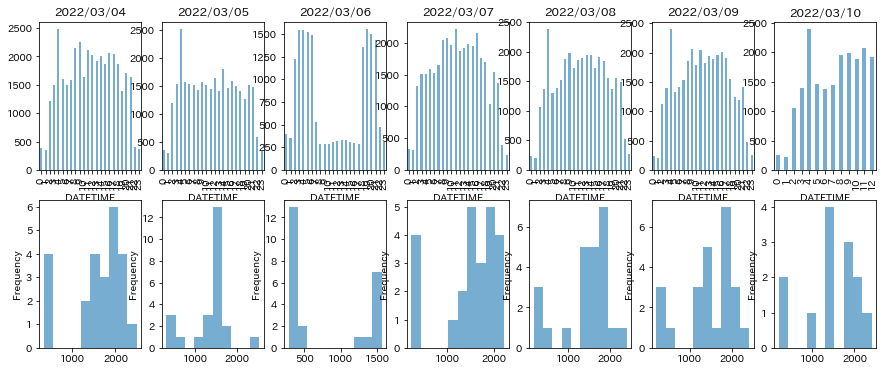

In [4]:
df_a = []
days = len(df.index.map(lambda x: x.date).unique())
fig, ax = plt.subplots(nrows=2, ncols=days, figsize=(15, 6))

i=0
for dd in df.index.map(lambda x: x.date).unique():
    dt0 = dt.datetime(dd.year, dd.month,dd.day)
    dt1 = dt0 + dt.timedelta(days=1)
    #df_a.append(df.loc[dt.datetime(dt0.year,dt0.month,dt0.day): dt.datetime(dt1.year,dt1.month,dt1.day)])
    df_t = (df.loc[dt.datetime(dt0.year,dt0.month,dt0.day): dt.datetime(dt1.year,dt1.month,dt1.day)])
    df_t.index = df_t.index.map(lambda x: x.hour)
    df_t = df_t.groupby(level=0).sum()
    df_t.plot.bar(ax=ax[0, i], alpha=0.6, legend=False,sharex=False, sharey=False)
    #df_t.plot(ax=ax[0, i], alpha=0.6, legend=False,sharex=False, sharey=False,style=['r.-'])
    ax[0, i].set_title(dt0.strftime('%Y/%m/%d'))
    df_t.plot(ax=ax[1, i], alpha=0.6, kind='hist', legend=False,stacked=True)
    #Y, X, _ = plt.hist(df_t, bins=10, alpha=0.5, ec='navy', legend=False)
    #print(X)
    #print(Y)
    i+=1
    
#df_t = df_a[0].copy()
#df_t.index = df_t.index.map(lambda x: x.hour)
#df_t = df_t.groupby(level=0).sum()
#df_t.plot.bar(figsize=(12,3))

In [5]:
import collections
import itertools

all_from_list = df['FROM_ADDR'].tolist()
c = collections.Counter(df['FROM_ADDR'].tolist())

tags = pd.Series(c)

In [6]:
#print(tags.sort_values(ascending=False)[:50])

#10.161.32.87     112492
#10.168.56.49      38165
#10.161.46.152      5039
#10.161.54.255      3415
#10.161.38.190      2557
#sesv302            1926
#svwarph1           1884
#se012866           1884
#df_ruby = df[df['FROM_ADDR'].apply(lambda x: '10.161.32.87' in x)]

In [15]:
df_tag = pd.DataFrame()
for t in tags.sort_values(ascending=False).index[:1]:
    print('- __{}__'.format(t))
    df_tag = df[df['FROM_ADDR'].apply(lambda x: t in x)].sort_values('COUNT', ascending=False)
    a = df_tag.reset_index().iterrows()
    print(a)
    #for i, row in df_tag[:100].reset_index().iterrows():
        #print('    - No.{0}: ({1[COUNT]} likes)'.format(i + 1, row))

- __10.161.32.87__
<generator object DataFrame.iterrows at 0x7fcca4231120>


In [17]:
df_tag_list = []
print(df_tag.info())
# 先頭10
top_tag_list = tags.sort_values(ascending=False).index[:10].tolist()

for t in top_tag_list:
    df_tag = df[df['FROM_ADDR'].apply(lambda x: t in x)]
    df_tag_list.append(df_tag[['COUNT']].resample('H').sum())

df_tags = pd.concat(df_tag_list, axis=1)
df_tags.columns = top_tag_list
print(df_tags)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1884 entries, 2022-03-04 00:00:00 to 2022-03-10 12:55:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PROTOCOL   1884 non-null   object
 1   TO_ADDR    1884 non-null   object
 2   TO_PORT    1884 non-null   object
 3   FROM_ADDR  1884 non-null   object
 4   FROM_PORT  1884 non-null   object
 5   STATUS     1884 non-null   object
 6   COUNT      1884 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 117.8+ KB
None
                     10.161.32.87  10.168.56.49  10.161.46.152  10.161.54.255  \
DATETIME                                                                        
2022-03-04 00:00:00           NaN           150            NaN             12   
2022-03-04 01:00:00           NaN           151            NaN             12   
2022-03-04 02:00:00         754.0           261            NaN             12   
2022-03-04 03:00:00         990.0           3

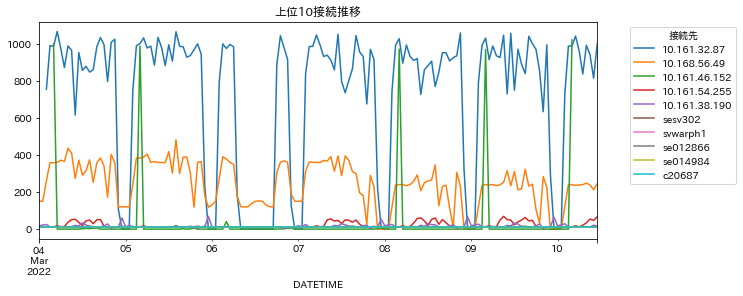

In [9]:
df_tags[:-1].plot(figsize=(10, 4), title='上位10接続推移')
plt.legend(title="接続先", bbox_to_anchor=(1.05, 1)) # <-- ココ
plt.show()

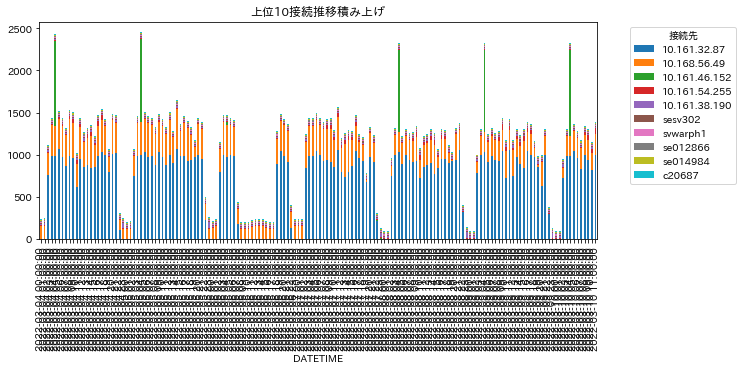

In [10]:
df_tags[:-1].plot.bar(stacked=True, figsize=(10, 4), title='上位10接続推移積み上げ')
plt.legend(title="接続先", bbox_to_anchor=(1.05, 1)) # <-- ココ
plt.show()